In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uszipcode import SearchEngine, SimpleZipcode
import plotly.graph_objects as go


/Users/rickypang/anaconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
filepath = '/Users/rickypang/Desktop/Project-2-Linkedin-Analysis/data/job_postings.csv'
df=pd.read_csv(filepath)

#convert date columns to date time
df['listed_time'] = pd.to_datetime(df['listed_time'], unit='ms')
df['original_listed_time'] = pd.to_datetime(df['original_listed_time'], unit='ms')
df['expiry']=pd.to_datetime(df['expiry'],unit='ms')

#convert company ID to an int, convert NaN to NaN
df['company_id'] = pd.to_numeric(df['company_id'], errors='coerce').astype('Int64')

#Pre-process and convert NaNs in company ID to -1
df['company_id'] = df['company_id'].fillna(-1)

#display df
pd.set_option('display.max_columns',None)
df

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,original_listed_time,remote_allowed,views,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,2023-11-04 09:26:40,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,https://careers-demant.icims.com/jobs/19601/he...,OffsiteApply,2023-12-04 08:53:20,NaN,Entry level,NaN,2023-11-04 09:26:40,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,2023-11-04 06:40:00,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,https://www.click2apply.net/mXLQz5S5NEYEXsKjwH...,OffsiteApply,2023-12-04 08:53:20,NaN,NaN,NaN,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,2023-11-04 06:40:00,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,https://www.click2apply.net/LwbOykH2yAJdahB5Ah...,OffsiteApply,2023-12-04 08:53:20,NaN,NaN,Bachelor's Degree in Mechanical Engineering pr...,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,2023-11-04 06:40:00,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,https://jobs.apploi.com/view/854782?utm_campai...,OffsiteApply,2023-12-04 08:53:20,NaN,Entry level,NaN,2023-11-04 06:40:00,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,2023-11-03 00:06:40,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,https://careers.iherb.com/global/en/job/IHINGL...,OffsiteApply,2023-12-04 08:53:20,NaN,Mid-Senior level,NaN,2023-11-04 09:26:40,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,2023-08-23 22:33:20,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,NaN,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,NaN,NaN,2023-08-23 22:33:20,NaN,0,FULL_TIME,NaN,NaN,1
33242,108965123,-1,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",2.0,2023-11-03 19:33:20,NaN,4.0,https://www.linkedin.com/jobs/view/108965123/?...,NaN,ComplexOnsiteApply,2023-12-03 19:00:00,NaN,NaN,NaN,2023-11-03 19:33:20,NaN,0,FULL_TIME,NaN,NaN,1699044401
33243,102339515,52132271,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...,NaN,NaN,NaN,NaN,Full-time,Greater Boston,NaN,2023-11-03 22:20:00,NaN,NaN,https://www.linkedin.com/jobs/view/102339515/?...,NaN,SimpleOnsiteApply,2023-12-03 21:46:40,NaN,NaN,NaN,2023-11-03 22:20:00,NaN,0,FULL_TIME,NaN,NaN,1699063495
33244,85008768,-1,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",NaN,2023-08-23 00:20:00,NaN,5.0,https://www.linkedin.com/jobs/view/85008768/?t...,NaN,ComplexOnsiteApply,2024-02-18 23:46:40,NaN,NaN,NaN,2023-08-23 00:20:00,NaN,1,FULL_TIME,USD,BASE_SALARY,1


In [3]:
df.isnull().sum()
#drop columns..
#closed time
#application url
#posting domain
#skills_desc (but add other dataset)
#clean industry column in the other dataset
#drop original listed time
df = df.drop(['closed_time', 'application_url', 'posting_domain', 'skills_desc', 'original_listed_time',], axis=1)




In [4]:

#other clean up
#location - some remote jobs list location as United States
#some list countries instead of cities
#look over remote allowed column - does null mean that remote is not allowed?
#go through job posting workflow 
#some cities are listed as san francisco bay area - this should include san mateo / sunnyvale?
#some jobs are listed in multiple cities for one actual job - how to deal with this?
#we dont know how accurate the views are because the views are a snapshot taken when the scrape was done (we dont know when the listing time was)
#job title standardization 

# Extracting city, state, and country
df[['City', 'State', 'Country']] = df['location'].str.extract(r'([^,]+)?,?\s?([^,]+)?,?\s?([^\d]+)?')

# Filling missing values in 'Country' with 'United States' if the state is present
df['Country'].fillna('United States', inplace=True)
df[['City', 'State', 'Country']]


,City,State,Country
0,Little River,SC,United States
1,Beaver Dam,WI,United States
2,Bessemer,AL,United States
3,Aliso Viejo,CA,United States
4,United States,NaN,United States
...,...,...,...
33241,Santa Clarita,CA,United States
33242,New York,NY,United States
33243,Greater Boston,NaN,United States
33244,Chico,CA,United States


In [5]:
df_sorted = df.sort_values(by='max_salary', ascending=False)
df_sorted

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country
27035,3694103424,92699700,Quantitative Developer,Goliath Partners has a requirement at a leadin...,1300000.0,NaN,800000.0,YEARLY,Full-time,Greater Chicago Area,14.0,NaN,49.0,https://www.linkedin.com/jobs/view/3694103424/...,ComplexOnsiteApply,2023-09-23 00:46:40,Mid-Senior level,2023-08-24 01:20:00,0,FULL_TIME,USD,BASE_SALARY,1,Greater Chicago Area,NaN,United States
17561,3701369748,106584,Fintech Startup | Tech Lead Manager - Software...,Tech Lead / Manager | Software EngineerSelby J...,1100000.0,NaN,500000.0,YEARLY,Full-time,United States,NaN,1.0,368.0,https://www.linkedin.com/jobs/view/3701369748/...,ComplexOnsiteApply,2023-09-21 21:00:00,Mid-Senior level,2023-08-22 21:33:20,0,FULL_TIME,USD,BASE_SALARY,1,United States,NaN,United States
18120,3701326157,106584,Tech Lead Manager (L6-L8) | Disruptive FinTech,Tech Lead Manager (L6-L8) | Disruptive FinTech...,1000000.0,NaN,750000.0,YEARLY,Full-time,"Palo Alto, CA",48.0,1.0,166.0,https://www.linkedin.com/jobs/view/3701326157/...,ComplexOnsiteApply,2023-12-20 19:20:00,Mid-Senior level,2023-08-23 22:33:20,1,FULL_TIME,USD,BASE_SALARY,1,Palo Alto,CA,United States
12010,3755585686,3560734,Life Science Consulting Partner,We set out to develop a health care innovation...,900000.0,NaN,400000.0,YEARLY,Full-time,"New York, NY",19.0,1.0,116.0,https://www.linkedin.com/jobs/view/3755585686/...,ComplexOnsiteApply,2023-12-03 21:46:40,Mid-Senior level,2023-11-03 19:33:20,0,FULL_TIME,USD,BASE_SALARY,1699059350,New York,NY,United States
30821,3693052192,-1,Urologist,Here are the Details: Location: DC/Baltimore ...,800000.0,NaN,600000.0,YEARLY,Full-time,"Baltimore, MD",NaN,NaN,6.0,https://www.linkedin.com/jobs/view/3693052192/...,ComplexOnsiteApply,2023-09-21 21:00:00,NaN,2023-08-22 21:33:20,0,FULL_TIME,USD,BASE_SALARY,1,Baltimore,MD,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,218881389,-1,Accounting Associate,My client a local office is seeking an Account...,NaN,NaN,NaN,NaN,Full-time,"Bolingbrook, IL",1.0,NaN,2.0,https://www.linkedin.com/jobs/view/218881389/?...,ComplexOnsiteApply,2023-12-03 21:46:40,NaN,2023-11-03 22:20:00,0,FULL_TIME,NaN,NaN,1699084455,Bolingbrook,IL,United States
33240,133196985,1089558,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",1.0,NaN,17.0,https://www.linkedin.com/jobs/view/133196985/?...,ComplexOnsiteApply,2023-09-21 18:13:20,NaN,2023-08-22 18:46:40,0,CONTRACT,NaN,NaN,1,New York,NY,United States
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Santa Clarita,CA,United States
33242,108965123,-1,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",2.0,NaN,4.0,https://www.linkedin.com/jobs/view/108965123/?...,ComplexOnsiteApply,2023-12-03 19:00:00,NaN,2023-11-03 19:33:20,0,FULL_TIME,NaN,NaN,1699044401,New York,NY,United States


In [6]:
# Identify duplicates based on 'company_id' and 'title'
duplicates_mask = df.duplicated(subset=['company_id', 'title'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates_mask]

# Display the duplicate rows - these rows signify listings that are the same title and same company - we have opted to leave these in the dataset
duplicate_rows

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,OffsiteApply,2023-12-04 08:53:20,Mid-Senior level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699085346,United States,NaN,United States
8,3757936097,18213359,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...",NaN,19.30,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757936097/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699089324,Aliso Viejo,CA,United States
14,3757935025,99500291,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,"St Clair Shores, Michigan, United States",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757935025/...,OffsiteApply,2023-12-04 06:06:40,Mid-Senior level,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699131931,St Clair Shores,Michigan,United States
16,3757935011,82556159,Remote Vacation Planner,Full Job Description\n\nWe are focused on prov...,NaN,NaN,NaN,NaN,Full-time,"Raleigh, NC",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757935011/...,OffsiteApply,2023-12-04 06:06:40,Entry level,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699084233,Raleigh,NC,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33219,2148434019,1016,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Connecticut, United States",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/2148434019/...,OffsiteApply,2023-09-23 03:33:20,Entry level,2023-08-24 04:06:40,0,FULL_TIME,NaN,NaN,1,Connecticut,United States,United States
33220,2148434014,1016,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Maine, United States",NaN,1.0,NaN,https://www.linkedin.com/jobs/view/2148434014/...,OffsiteApply,2023-09-23 03:33:20,Entry level,2023-08-24 04:06:40,0,FULL_TIME,NaN,NaN,1,Maine,United States,United States
33227,1535492735,-1,Administrative Assistant,We are looking for a responsible Administrativ...,20.0,NaN,18.0,HOURLY,Part-time,"Ocoee, FL",3.0,NaN,5.0,https://www.linkedin.com/jobs/view/1535492735/...,ComplexOnsiteApply,2024-02-18 21:00:00,NaN,2023-08-22 21:33:20,0,PART_TIME,USD,BASE_SALARY,1,Ocoee,FL,United States
33229,1483357774,-1,Video Editor,POSITION: Lead EditorREPORTS TO: Founder and D...,NaN,NaN,NaN,NaN,Full-time,"Louisville, KY",7.0,NaN,40.0,https://www.linkedin.com/jobs/view/1483357774/...,ComplexOnsiteApply,2023-09-21 18:13:20,NaN,2023-08-22 18:46:40,0,FULL_TIME,NaN,NaN,1,Louisville,KY,United States


/var/folders/5n/f53vsb0n34q3sstd084mv7g80000gn/T/ipykernel_21089/3928678452.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c=df.corr()
/var/folders/5n/f53vsb0n34q3sstd084mv7g80000gn/T/ipykernel_21089/3928678452.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.ones_like(c, dtype=np.bool)


<Axes: >

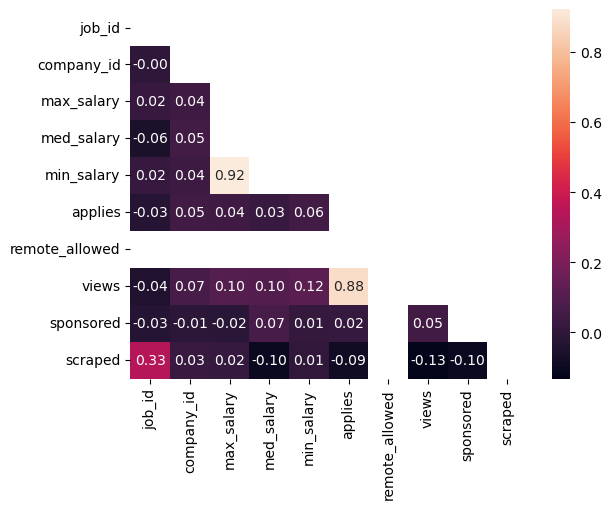

In [7]:
c=df.corr()
mask=np.ones_like(c, dtype=np.bool)
mask=np.triu(mask)
sns.heatmap(c, annot=True, fmt=".2f", annot_kws={"size": 10},mask=mask)

In [8]:
filepathforcompany = '/Users/rickypang/Desktop/Project-2-Linkedin-Analysis/data/company_details/companies.csv'
filepathforjob = '~/Downloads/data-for-project-2/job_details/job_industries.csv'
filepathforindustry = '~/Downloads/data-for-project-2/maps/industries.csv'

df2 = pd.read_csv(filepathforcompany)

df3=pd.read_csv(filepathforjob)
df4=pd.read_csv(filepathforindustry)


In [9]:
df3 = df3.drop_duplicates(subset='job_id', keep='first')
df3.nunique()

job_id         33090
industry_id      222
dtype: int64

In [10]:
#left join df with company info on company_id
result_df = pd.merge(df, df2, on='company_id', how='left')
result_df=pd.merge(result_df,df3, on='job_id',how='left')
result_df=pd.merge(result_df,df4, on='industry_id',how='left')

#replace the -1s with NaN in company_id
result_df['company_id'] = result_df['company_id'].replace(-1, np.nan)

#show the new df - remote allowed and missing location
filtered_rows = result_df[(result_df['remote_allowed'] == 1.0) & result_df['zip_code'].isna()]
filtered_rows


,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name
566,3757908631,<NA>,Structural/Miscellaneous Detailer,Company DescriptionWe suggest you enter detail...,NaN,NaN,NaN,NaN,Full-time,United States,6.0,1.0,12.0,https://www.linkedin.com/jobs/view/3757908631/...,ComplexOnsiteApply,2023-12-04 06:06:40,NaN,2023-11-04 03:53:20,0,FULL_TIME,NaN,NaN,1699083269,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,3757752019,<NA>,Customer Service Representative,Star City Staffing was founded in 2020 with a ...,NaN,NaN,NaN,NaN,Full-time,United States,20.0,1.0,58.0,https://www.linkedin.com/jobs/view/3757752019/...,ComplexOnsiteApply,2023-12-04 00:33:20,NaN,2023-11-04 01:06:40,0,FULL_TIME,NaN,NaN,1699082602,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1235,3757751157,<NA>,Real Estate Agent,Help Wanted: Real Estate Agents\n\nAre you a m...,NaN,NaN,NaN,NaN,Contract,United States,3.0,1.0,43.0,https://www.linkedin.com/jobs/view/3757751157/...,SimpleOnsiteApply,2023-12-04 00:33:20,NaN,2023-11-04 01:06:40,0,CONTRACT,NaN,NaN,1699135161,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,3757749881,<NA>,UI/UX Designer,We are seeking a talented UI/UX Designer to jo...,NaN,NaN,NaN,NaN,Full-time,"Louisiana, United States",162.0,1.0,298.0,https://www.linkedin.com/jobs/view/3757749881/...,ComplexOnsiteApply,2024-05-02 00:33:20,NaN,2023-11-04 01:06:40,0,FULL_TIME,NaN,NaN,1699080458,Louisiana,United States,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1354,3757748411,<NA>,Personal Assistant to Chief Executive Officer,Position Overview:\nAs a remote personal assis...,NaN,NaN,NaN,NaN,Full-time,United States,209.0,1.0,519.0,https://www.linkedin.com/jobs/view/3757748411/...,ComplexOnsiteApply,2024-05-02 00:33:20,NaN,2023-11-04 01:06:40,1,FULL_TIME,NaN,NaN,1699080680,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32936,3691797973,145145,Sales Specialist,Looking for a Business development specialist ...,NaN,NaN,NaN,NaN,Full-time,United States,NaN,1.0,9.0,https://www.linkedin.com/jobs/view/3691797973/...,ComplexOnsiteApply,2023-09-20 20:00:00,Executive,2023-08-21 17:46:40,0,FULL_TIME,NaN,NaN,1,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,Pharmaceutical Manufacturing
32941,3691795980,7573454,Data Engineer,"Job Description:\n• Design, develop, and launc...",NaN,NaN,NaN,NaN,Contract,United States,55.0,1.0,101.0,https://www.linkedin.com/jobs/view/3691795980/...,ComplexOnsiteApply,2023-09-20 20:00:00,NaN,2023-08-21 17:46:40,0,CONTRACT,NaN,NaN,1,United States,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,IT Services and IT Consulting
33021,3690697852,<NA>,Manufacturers' Outside Sales Representative,DH Sales Company is a growing Manufacturers’ R...,NaN,NaN,NaN,NaN,Full-time,"Charlotte, NC",90.0,1.0,430.0,https://www.linkedin.com/jobs/view/3690697852/...,ComplexOnsiteApply,2024-02-06 17:20:00,NaN,2023-08-10 17:53:20,1,FULL_TIME,NaN,NaN,1,Charlotte,NC,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33124,3644195109,<NA>,Call Center Representative,This is a 1099 position. Pay is based off of t...,NaN,NaN,NaN,NaN,Full-time,Atlanta Metropolitan Area,1.0,1.0,2.0,https://www.linkedin.com/jobs/view/3644195109/...,ComplexOnsiteApply,2023-09-22 22:00:00,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Atlanta Metropolitan Area,NaN,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
len(result_df)

33246

In [12]:
result_df['currency'].unique()

array(['USD', nan], dtype=object)

In [13]:
# Create a function to fetch city, state, median home value, and median household income information
def get_zipcode_info(zipcode):
    search = SearchEngine()
    result = search.by_zipcode(zipcode)
    
    if result:
        return result.major_city, result.state, result.median_home_value, result.median_household_income, result.state_abbr
    else:
        return None, None, None, None, None

# Apply the function to create new columns
result_df[['major_city', 'state', 'median_home_value', 'median_household_income', 'state_abbr']] = result_df['zip_code'].apply(lambda x: pd.Series(get_zipcode_info(x)))

In [14]:
result_df['state_match'] = result_df['state'] == result_df['state_abbr']

# Filter the DataFrame to show only rows where there is a mismatch
mismatch_df = result_df[result_df['state_match'] == False]

# Display the DataFrame with mismatches
len(mismatch_df)

6265

In [15]:
result_df

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name,major_city,median_home_value,median_household_income,state_abbr,state_match
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699138101,Little River,SC,United States,HearingLife,HearingLife is a national hearing care company...,5.0,NJ,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,17.0,Medical Equipment Manufacturing,Somerset,332400.0,85148.0,NJ,True
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085644,Bessemer,AL,United States,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,IL,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,147.0,Automation Machinery Manufacturing,Wheeling,193200.0,58466.0,IL,True
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,CA,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,100.0,Non-profit Organizations,Altadena,550000.0,85108.0,CA,True
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,OffsiteApply,2023-12-04 08:53:20,Mid-Senior level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699085346,United States,NaN,United States,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,CA,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb,27.0,Retail,Irvine,516400.0,92862.0,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Santa Clarita,CA,United States,CargoLogin.,CargoLogin is a freight and logistics company ...,1.0,NC,US,Santa Clarita,28358,Constellation Rd,https://www.linkedin.com/company/cargologinllc,92.0,Truck Transportation,Lumber

## Below we are filtering outliers and creating a new column for mean salary

In [16]:
# Adding the 'mean_salary' column with NaN handling
result_df['mean_salary'] = np.where(result_df[['max_salary', 'min_salary']].isna().any(axis=1), np.nan, (result_df['max_salary'] + result_df['min_salary']) / 2)

In [17]:
# We can see there are a lot of outliers in this dataset. 
# Lets use the inter quartile range to find the outliers 

Q1 = result_df['mean_salary'].quantile(0.25)
Q3 = result_df['mean_salary'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = result_df[(result_df['mean_salary'] < Q1 - threshold * IQR) | (result_df['mean_salary'] > Q3 + threshold * IQR)]

In [18]:
outliers

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name,major_city,median_home_value,median_household_income,state_abbr,state_match,mean_salary
142,3757924020,2908367,Search Consultant / Recruiter,"gpac, a family-owned executive search firm, is...",500000.0,NaN,200000.0,YEARLY,Full-time,"New London, WI",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757924020/...,OffsiteApply,2023-12-04 06:06:40,Mid-Senior level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699082898,New London,WI,United States,gpac,Growing people and companies since 1990 with a...,4.0,SD,US,Sioux Falls,57108,5900 s W Doral Ct,https://www.linkedin.com/company/gogpac,137.0,Human Resources Services,Sioux Falls,264800.0,86182.0,SD,True,350000.0
297,3757915671,18577044,Obstetrician/Gynecologist,Providence Medical Group's Women's Health serv...,446745.0,NaN,309588.0,YEARLY,Full-time,"Everett, WA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757915671/...,SimpleOnsiteApply,2023-12-04 06:06:40,Mid-Senior level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699084381,Everett,WA,United States,Provider Solutions & Development,"Tell us your why, we'll find your where. \n \n...",2.0,WA,US,Renton,98057,1801 Lind Ave SW,https://www.linkedin.com/company/provider-solu...,14.0,Hospitals and Health Care,Renton,256900.0,43339.0,WA,True,378166.5
473,3757911572,3608,"Principal Software Engineer, MLOps Infrastructure",We are looking for a Principal Software Engine...,414000.0,NaN,268000.0,YEARLY,Full-time,"California, United States",4.0,1.0,82.0,https://www.linkedin.com/jobs/view/3757911572/...,OffsiteApply,2023-12-04 06:06:40,Director,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699132305,California,United States,United States,NVIDIA,"Since its founding in 1993, NVIDIA (NASDAQ: NV...",7.0,CA,US,Santa Clara,95050,2701 San Tomas Expressway,https://www.linkedin.com/company/nvidia,3.0,Computer Hardware Manufacturing,Santa Clara,601400.0,67630.0,CA,True,341000.0
502,3757910899,3608,Deep Learning Algorithms Manager,We are now looking for a Deep Learning Algorit...,414000.0,NaN,216000.0,YEARLY,Full-time,"Santa Clara, CA",1.0,NaN,6.0,https://www.linkedin.com/jobs/view/3757910899/...,OffsiteApply,2023-12-04 06:06:40,Mid-Senior level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699081419,Santa Clara,CA,United States,NVIDIA,"Since its founding in 1993, NVIDIA (NASDAQ: NV...",7.0,CA,US,Santa Clara,95050,2701 San Tomas Expressway,https://www.linkedin.com/company/nvidia,3.0,Computer Hardware Manufacturing,Santa Clara,601400.0,67630.0,CA,True,315000.0
582,3757908157,17937,Director of Key Accounts (Beauty),Job title: Director of Key Accounts (Beauty)\n...,450352.0,NaN,150000.0,YEARLY,Contract,"New York, United States",4.0,NaN,26.0,https://www.linkedin.com/jobs/view/3757908157/...,OffsiteApply,2023-12-04 03:20:00,Director,2023-11-04 03:53:20,0,CONTRACT,USD,BASE_SALARY,1699132980,New York,United States,United States,24 Seven Talent,THE 24 SEVEN FAMILY OF COMPANIES\n24 Seven is ...,3.0,NY,US,New York,10010,41 Madison Ave,https://www.linkedin.com/company/24seventalent,104.0,Staffing and Recruiting,New York,746200.0,97955.0,NY,True,300176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27035,3694103424,92699700,Quantitative Developer,Goliath Partners has a requirement at a leadin...,1300000.0,NaN,800000.0,YEARLY,Full-time,Greater Chicago Area,14.0,NaN,49.0,https://www.linkedin.com/jobs/view/3694103424/...,ComplexOnsiteApply,2023-09-23 00:46:40,Mid-Senior level,2023-08-24 01:20:00,0,FULL_TIME,USD,BASE_SALARY,1,Greater Chicago Ar

In [19]:
len(result_df)

33246

In [20]:
result_df = result_df[~((result_df['mean_salary'] < Q1 - threshold * IQR) | (result_df['mean_salary'] > Q3 + threshold * IQR))]

In [21]:
len(result_df)+len(outliers)==33246

True

## The result_df is now clean from this point forward ##

## Below this cell is used for hypothesis 2 data wrangling ##

In [22]:
#this cell will be used for hypothesis 2
#skill level

filepathforskill = '~/Downloads/data-for-project-2/job_details/job_skills.csv'
filepathforskillfull='~/Downloads/data-for-project-2/maps/skills.csv'

df5=pd.read_csv(filepathforskill)

df6=pd.read_csv(filepathforskillfull)

df6

,skill_abr,skill_name
0,PRCH,Purchasing
1,SUPL,Supply Chain
2,PR,Public Relations
3,SCI,Science
4,STRA,Strategy/Planning
5,WRT,Writing/Editing
6,QA,Quality Assurance
7,DIST,Distribution
8,PROD,Production
9,PRJM,Project Management


In [23]:
df5 = df5.drop_duplicates(subset='job_id', keep='first')
df6 = df6.drop_duplicates(subset='skill_abr', keep='first')

In [24]:
#left join skills to main table
result_df_ricky=result_df.merge(df5,on='job_id',how='left')
result_df_ricky=pd.merge(result_df_ricky,df6,on='skill_abr',how='left')
result_df_ricky

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,views,job_posting_url,application_type,expiry,formatted_experience_level,listed_time,sponsored,work_type,currency,compensation_type,scraped,City,State,Country,name,description_y,company_size,state,country,city,zip_code,address,url,industry_id,industry_name,major_city,median_home_value,median_household_income,state_abbr,state_match,mean_salary,skill_abr,skill_name
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699138101,Little River,SC,United States,HearingLife,HearingLife is a national hearing care company...,5.0,NJ,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,17.0,Medical Equipment Manufacturing,Somerset,332400.0,85148.0,NJ,True,NaN,OTHR,Other
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085420,Beaver Dam,WI,United States,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,135.0,Industrial Machinery Manufacturing,Mayville,149500.0,57292.0,WI,True,NaN,MGMT,Management
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,OffsiteApply,2023-12-04 08:53:20,NaN,2023-11-04 06:40:00,0,FULL_TIME,NaN,NaN,1699085644,Bessemer,AL,United States,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,IL,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,147.0,Automation Machinery Manufacturing,Wheeling,193200.0,58466.0,IL,True,NaN,ENG,Engineering
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,OffsiteApply,2023-12-04 08:53:20,Entry level,2023-11-04 06:40:00,0,FULL_TIME,USD,BASE_SALARY,1699087461,Aliso Viejo,CA,United States,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,CA,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,100.0,Non-profit Organizations,Altadena,550000.0,85108.0,CA,True,NaN,MGMT,Management
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,OffsiteApply,2023-12-04 08:53:20,Mid-Senior level,2023-11-04 09:26:40,0,FULL_TIME,USD,BASE_SALARY,1699085346,United States,NaN,United States,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,CA,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb,27.0,Retail,Irvine,516400.0,92862.0,CA,True,240895.0,IT,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33172,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/133114754/?...,ComplexOnsiteApply,2023-09-23 00:46:40,NaN,2023-08-23 22:33:20,0,FULL_TIME,NaN,NaN,1,Santa Clarita,CA,United States,CargoLogin.,CargoLogin is a freig

## The cells below are for skill level and skill name analysis ##

In [25]:
result_df_ricky.columns
# Group by 'skill_name' and count the occurrences
skill_counts = result_df_ricky['skill_name'].value_counts().reset_index()

# Rename the columns for clarity
skill_counts.columns = ['skill_name', 'count']

skill_counts

,skill_name,count
0,Management,4410
1,Health Care Provider,3663
2,Sales,3294
3,Engineering,3130
4,Information Technology,2818
5,Other,2625
6,Accounting/Auditing,1430
7,Finance,1165
8,Marketing,1140
9,Administrative,962


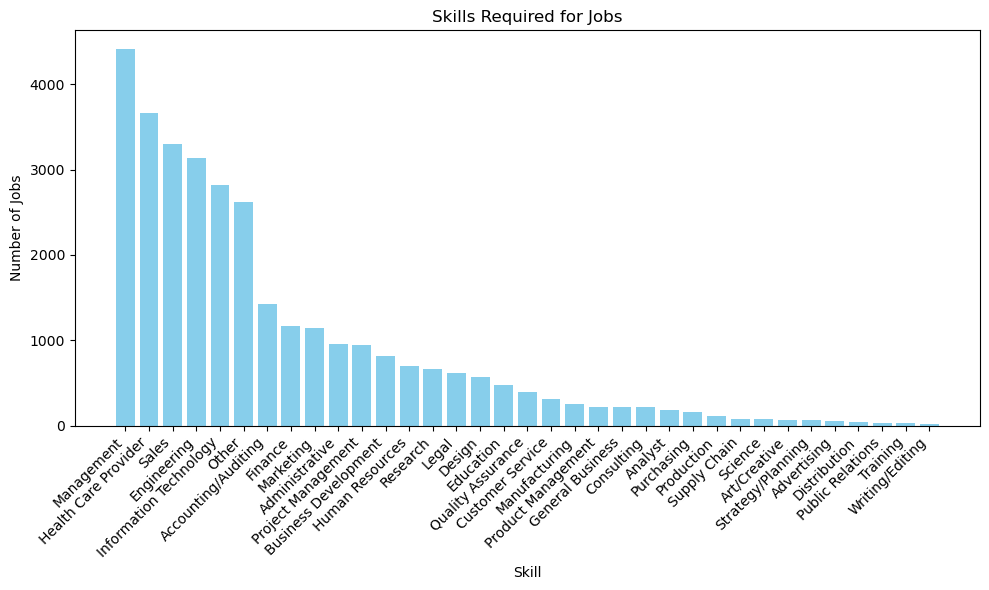

In [26]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(skill_counts['skill_name'], skill_counts['count'], color='skyblue')
plt.xlabel('Skill')
plt.ylabel('Number of Jobs')
plt.title('Skills Required for Jobs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [27]:
skills_by_level=result_df_ricky.groupby(['skill_name','formatted_experience_level']).size().reset_index(name='count')
skills_by_level

,skill_name,formatted_experience_level,count
0,Accounting/Auditing,Associate,227
1,Accounting/Auditing,Director,68
2,Accounting/Auditing,Entry level,218
3,Accounting/Auditing,Executive,14
4,Accounting/Auditing,Internship,26
...,...,...,...
190,Training,Mid-Senior level,17
191,Writing/Editing,Associate,8
192,Writing/Editing,Director,2
193,Writing/Editing,Entry level,2


In [50]:
pivot_df = skills_by_level.pivot(index='skill_name', columns='formatted_experience_level', values='count')

# Sum the counts across all experience levels for each skill
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort the DataFrame based on the total count in descending order
pivot_df = pivot_df.sort_values(by='Total', ascending=False)

# Reorder columns to match the specified order
desired_order = ['Internship','Entry level','Associate','Mid-Senior level','Director', 'Executive']
pivot_df = pivot_df[desired_order]

<Axes: xlabel='formatted_experience_level', ylabel='skill_name'>

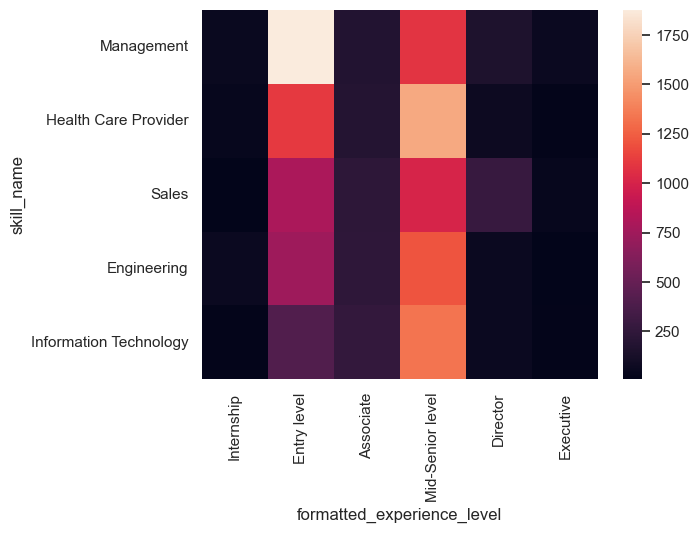

In [51]:
sns.heatmap(pivot_df.head())

In [52]:
skills_by_level['formatted_experience_level'].unique()

array(['Associate', 'Director', 'Entry level', 'Executive', 'Internship',
       'Mid-Senior level'], dtype=object)

<Figure size 1200x600 with 0 Axes>

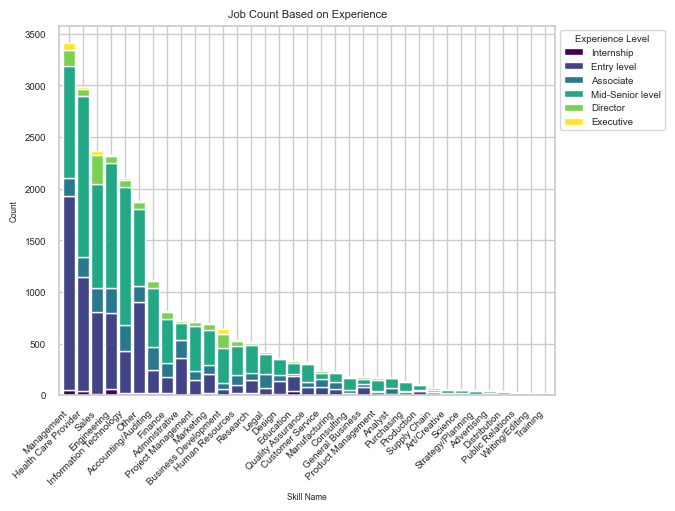

In [53]:
# Sum the counts across all experience levels for each skill
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort the DataFrame based on the total count in descending order
pivot_df = pivot_df.sort_values(by='Total', ascending=False)

# Drop the 'Total' column if you don't want it in the plot
pivot_df = pivot_df.drop(columns=['Total'])

# Increase the width of the plot area
plt.figure(figsize=(12, 6))  # Adjust the width as needed
sns.set(style="whitegrid")  # Optional, but it enhances the appearance of the plot
ax = pivot_df.plot(kind='bar', stacked=True, colormap='viridis', width=0.9)
plt.xlabel('Skill Name', fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Job Count Based on Experience', fontsize=8)
plt.legend(title='Experience Level', bbox_to_anchor=(1, 1), loc='upper left', fontsize=7, title_fontsize=7) 
plt.xticks(rotation=45, ha='right', fontsize=7.1)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=7)
plt.show()

In [42]:
skill_salary=result_df_ricky.groupby(['skill_name']).mean('mean_salary')
skill_salary

,job_id,company_id,max_salary,med_salary,min_salary,applies,remote_allowed,views,sponsored,scraped,company_size,industry_id,median_home_value,median_household_income,state_match,mean_salary
skill_name,,,,,,,,,,,,,,,,
Accounting/Auditing,3.717466e+09,10453363.53051,89394.605867,39261.196786,70560.417295,12.184560,1.0,41.140308,0.323776,8.614165e+08,4.046512,77.769231,435909.998333,76992.561667,0.857343,79977.511581
Administrative,3.716952e+09,10845309.861736,48183.957013,14969.078375,36942.955013,16.106529,1.0,59.756098,0.268191,9.449082e+08,4.348677,78.336170,409071.066038,73687.053908,0.814969,42563.456013
Advertising,3.738204e+09,3719746.6,105193.206897,22510.000000,69507.862069,7.604651,1.0,39.839286,0.133333,1.217665e+09,4.916667,109.716667,657352.868421,89000.394737,0.633333,87350.534483
Analyst,3.731512e+09,10162331.634831,69235.564096,15380.500000,55888.438675,35.228571,1.0,100.568182,0.296089,1.015646e+09,4.284722,52.983240,414989.942446,79062.258993,0.804469,62562.001386
Art/Creative,3.722962e+09,6921754.287879,83820.000000,250749.600000,61088.818182,40.245283,1.0,150.107692,0.313433,7.607764e+08,4.575758,63.880597,483475.473684,80535.666667,0.880597,72454.409091
Business Development,3.721468e+09,13157290.924035,114088.135934,101085.714722,77832.600361,18.643312,1.0,65.108484,0.218249,9.113362e+08,4.286842,138.973913,437434.096718,82302.196891,0.839704,95960.368148
Consulting,3.725825e+09,6878482.672897,99888.075467,77859.222222,71069.506533,20.600000,1.0,64.107843,0.216590,8.456188e+08,4.420290,133.432558,440294.541096,80588.458904,0.728111,85478.791000
Customer Service,3.715172e+09,6201295.158416,32309.134184,9010.593214,24783.060213,22.555556,1.0,65.648000,0.294498,8.247922e+08,4.900685,52.588997,412659.695473,74669.304527,0.815534,28546.097199
Design,3.710858e+09,12888036.888288,76750.506616,19438.776774,54026.510758,28.347222,1.0,88.500000,0.233333,8.703999e+08,4.280702,131.382406,429657.802247,78543.271910,0.792982,65388.508687


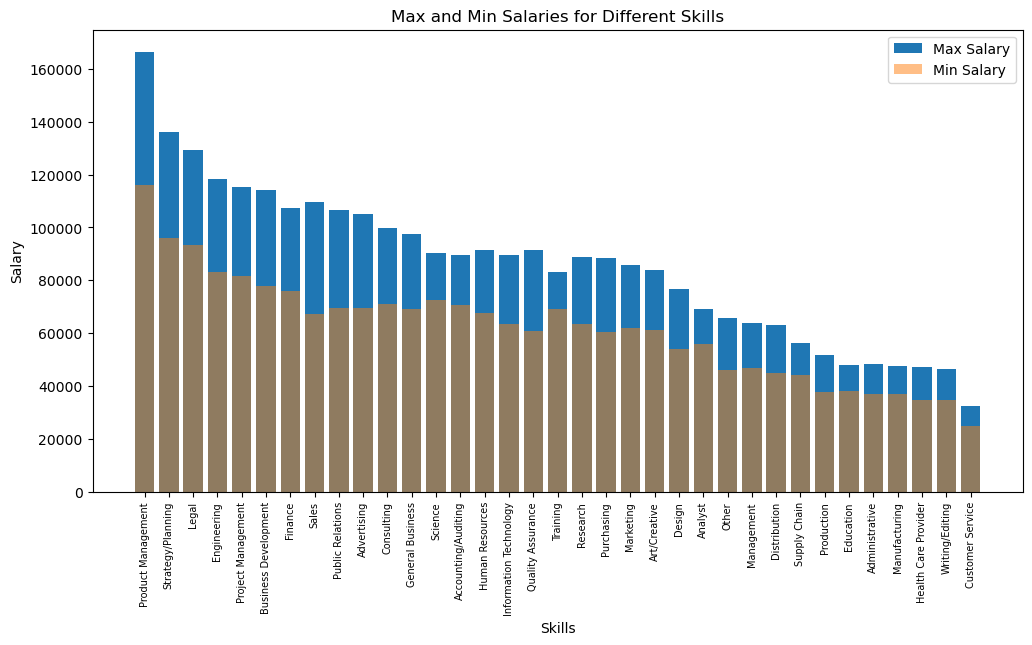

In [33]:
skill_salary=skill_salary.sort_values(by='mean_salary', ascending=False)
#plotting max and min salaries for skills
plt.figure(figsize=(12, 6))
plt.bar(skill_salary.index,skill_salary['max_salary'],label='Max Salary')

plt.bar(skill_salary.index, skill_salary['min_salary'], label='Min Salary', alpha=0.5)

plt.xticks(rotation=90,fontsize=7)

plt.xlabel('Skills')
plt.ylabel('Salary')
plt.title('Max and Min Salaries for Different Skills')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [34]:
skill_salary[['max_salary','med_salary','min_salary']].sort_values('max_salary', ascending=False).head()

#reformat to dollars

,max_salary,med_salary,min_salary
skill_name,,,
Product Management,166460.572727,285018.285714,116011.481818
Strategy/Planning,136188.567568,70147.096667,95981.162162
Legal,129217.576838,124654.740000,93157.661203
Engineering,118428.822321,65356.603978,83126.901792
Project Management,115321.702461,77037.472222,81476.752073


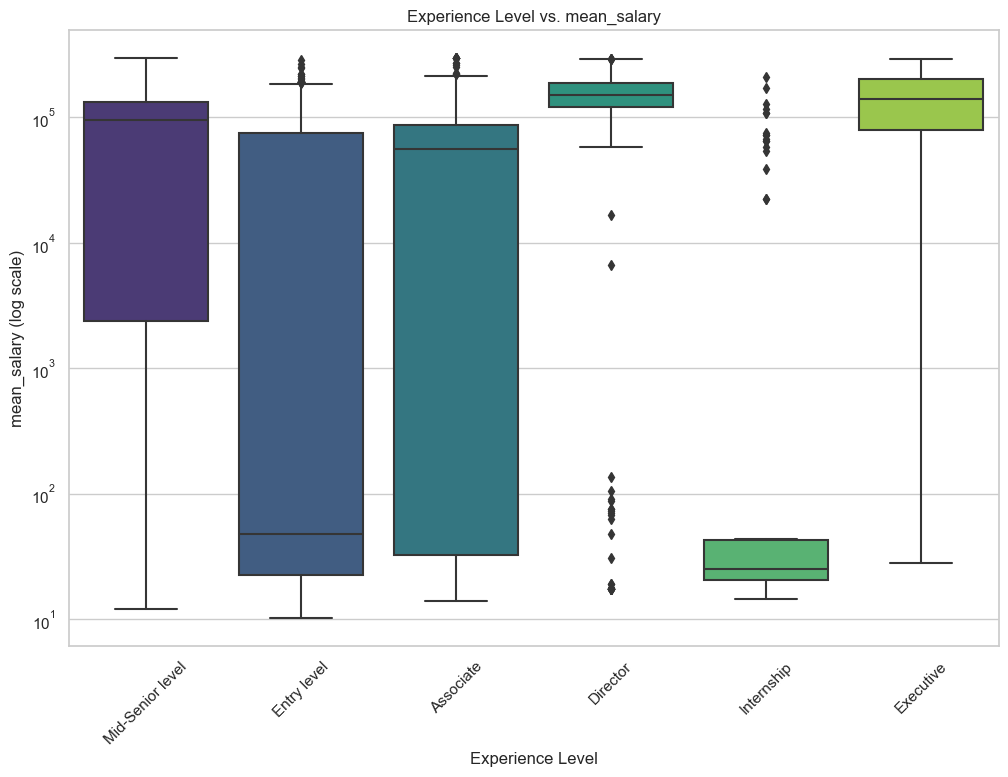

In [39]:
# Filter out rows with null values in 'formatted_experience_level' and 'med_salary'
filtered_df = result_df_ricky.dropna(subset=['formatted_experience_level', 'mean_salary'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='formatted_experience_level', y='mean_salary', data=filtered_df, palette='viridis')

# Set plot labels and title
plt.xlabel('Experience Level')
plt.ylabel('mean_salary (log scale)')
plt.title('Experience Level vs. mean_salary')
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

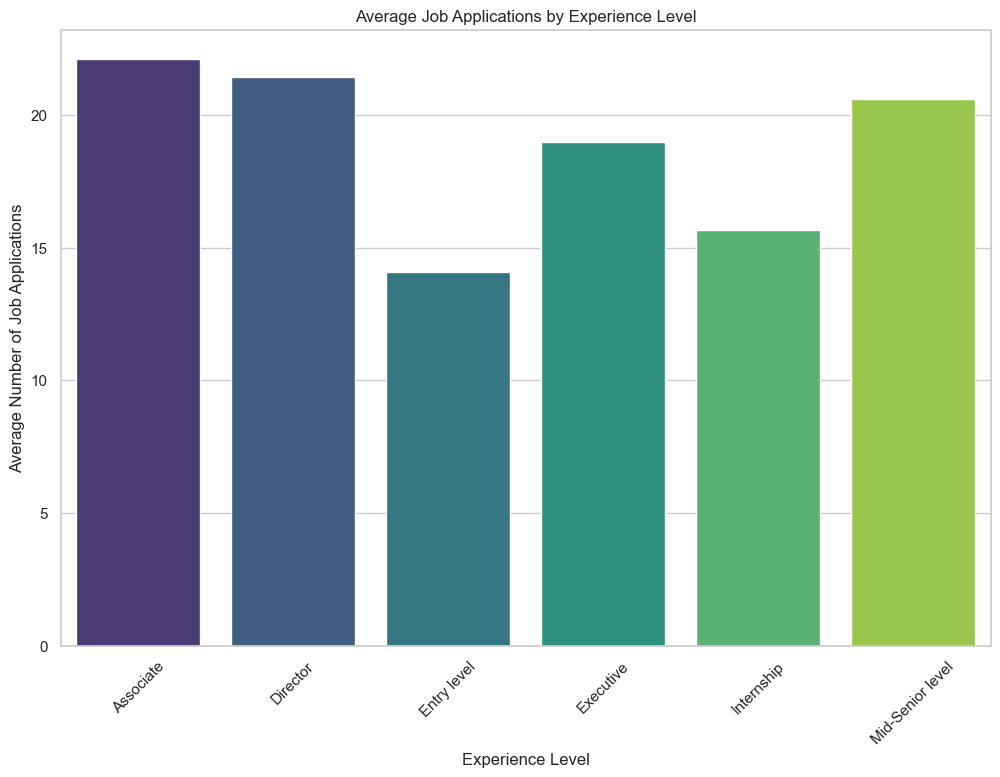

In [38]:
# Group the data by 'formatted_experience_level' and calculate the average number of job applications
average_applications_by_experience = result_df_ricky.groupby('formatted_experience_level')['applies'].mean().reset_index()

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='formatted_experience_level', y='applies', data=average_applications_by_experience, palette='viridis')

# Set plot labels and title
plt.xlabel('Experience Level')
plt.ylabel('Average Number of Job Applications')
plt.title('Average Job Applications by Experience Level')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

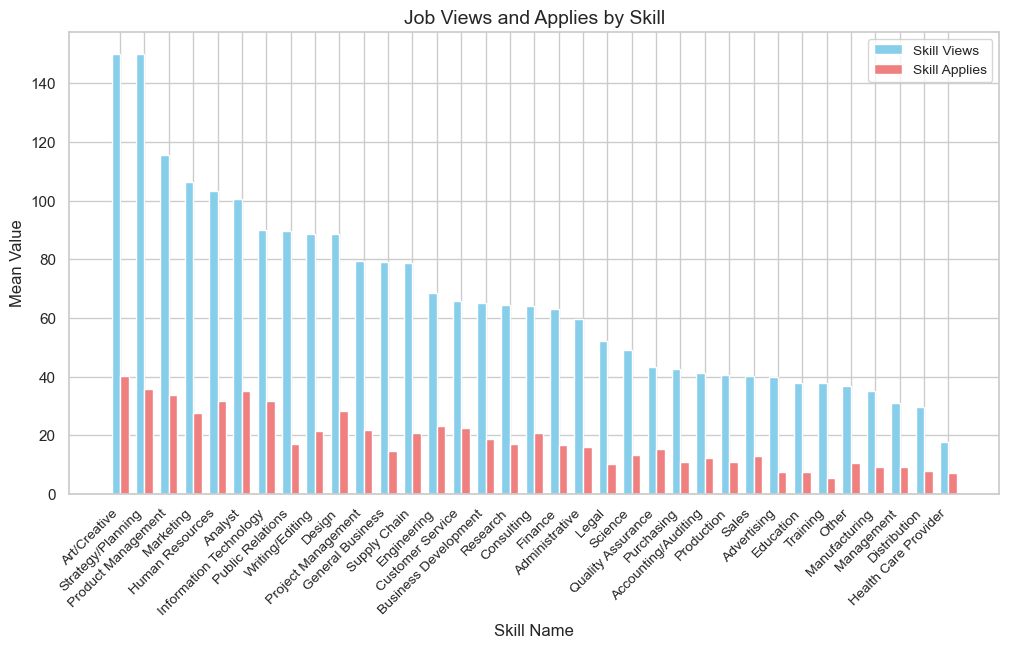

In [37]:
# Group by 'skill_name' and calculate the mean of 'views' and 'applies'
skill_views = result_df_ricky.groupby('skill_name')['views'].mean()
skill_applies = result_df_ricky.groupby('skill_name')['applies'].mean()

# Sort the Series in descending order based on mean views and applies
skill_views = skill_views.sort_values(ascending=False)
skill_applies = skill_applies.sort_values(ascending=False)

# Create a side-by-side bar chart
width = 0.35  # Width of the bars
ind = np.arange(len(skill_views))  # The x locations for the groups

plt.figure(figsize=(12, 6))  # Adjust the width as needed

# Plot bars for skill views
plt.bar(ind, skill_views.values, width, label='Skill Views', color='skyblue')

# Plot bars for skill applies next to the skill views bars
plt.bar(ind + width, skill_applies[skill_views.index].values, width, label='Skill Applies', color='lightcoral')

plt.xlabel('Skill Name', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.title('Job Views and Applies by Skill', fontsize=14)
plt.xticks(ind + width / 2, skill_views.index, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)
plt.show()

## Hypothesis 2 end here ##

In [ ]:
average_salary_by_state = result_df.groupby('state_abbr')['mean_salary'].mean().reset_index()
average_salary_by_state

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=average_salary_by_state['state_abbr'],
    z=average_salary_by_state['mean_salary'],
    locationmode='USA-states',
    colorscale='Viridis',  # You can choose a different colorscale
    zmin=average_salary_by_state['mean_salary'].min(),  # Set the minimum value of the color scale
    zmax=average_salary_by_state['mean_salary'].max(),  # Set the maximum value of the color scale
    colorbar=dict(
        title='Mean Salary',
        tickprefix='$',  # Add a dollar sign as a prefix to colorbar ticks
        ticks='outside',  # Place colorbar ticks outside the colorbar
        ticklen=5,  # Set the length of the tick marks
        tickmode='array',  # Set the tick mode to 'array' for custom ticks
        tickvals=[10000, 50000, 100000,150000],  # Customize the colorbar tick values
    )
))

fig.update_layout(
    title_text='LinkedIn Salaries by State',
    geo=dict(
        showlakes=True,
        projection=go.layout.geo.Projection(type='albers usa'),
        scope='usa'
    )
)

fig.show()

In [ ]:
result_df['month_year'] = result_df['expiry'].dt.to_period('D')
monthly_counts = result_df['month_year'].value_counts().sort_index()
monthly_counts_df = pd.DataFrame({'month_year': monthly_counts.index, 'count': monthly_counts.values})
monthly_counts_df = monthly_counts_df.sort_values(by='month_year')
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts_df['month_year'].dt.to_timestamp(), monthly_counts_df['count'], marker='o', linestyle='-')
plt.title('Job Postings per Month')
plt.xlabel('Month and Year')
plt.ylabel('Job Postings')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#This cell looks at record count for job titles and attempts to clean

result_df['Title_Count'] = result_df.groupby('title')['title'].transform('count')

title_result_df_sorted = result_df.sort_values(by='Title_Count', ascending=False)

# Filter rows for City Lifestyle postings
filtered_result_df = title_result_df_sorted[title_result_df_sorted['url'] != 'https://www.linkedin.com/company/citylifestyle']

# Display the filtered DataFrame
print(filtered_result_df)


In [ ]:
df['title'].value_counts()


In [ ]:
#Plot a bar plot of the top 10 job titles posted on LinkedIn
fig = result_df.groupby('title')['title'].count().sort_values(ascending=False).head(10).plot.bar()
plt.xlabel('Job Title')
plt.ylabel('Number of posts')
plt.title("Most in-demand jobs posted on LinkedIn")


In [ ]:
#this cell groups by location and returns the mean salary for each location

average_values = df.groupby('location')['med_salary'].mean().reset_index()

result_df = df.groupby('location')['med_salary'].agg(['mean', 'count']).reset_index()

result_df.columns = ['Location', 'Mean', 'Salary Count']

In [ ]:
#this cell sorts by the avg med salary and adds a column that keeps track of how many jobs offer that avg salary

average_values_sorted = average_values.sort_values(by='med_salary', ascending=False)

result_df_sorted = result_df.sort_values(by='Mean', ascending=False)

# Assuming result_df_sorted is the DataFrame you want to modify
result_df_filtered = result_df_sorted.loc[result_df_sorted['Salary Count'] > 1]

# Display the sorted result
print(average_values_sorted)

# Display the modified DataFrame
print(result_df_filtered)

In [ ]:
# Plot a scatter plot of the locations with the 10 highest mean salary
result_df_filtered.head(10).plot.scatter(x='Location', y='Mean')
plt.xticks(rotation=90)
plt.xlabel("Job Location")
plt.ylabel("Mean Salary")
plt.title("Location of top mean salaries posted on LinkedIn")

In [ ]:
result_df.columns

In [ ]:
#Experience level, Skills)
#Question, Augmentation, Analysis, Visualization
